<style>
h1 {text-align: center; font-family: Georgia; font-size: 36px; font-weight: bold; line-height: 48px}
h2 {font-family: Calisto MT; font-size: 30px; font-weight: bold; color: #6a085c}
h3 {font-family: Lucida Bright; font-size: 24px; font-weight: bold; color: #114a4f}
h4 {text-indent: 2em; font-family: Cambria; font-size: 18px}
p.text {text-indent: 2em; text-align: justify; font-family: Times New Roman; font-size: 20px}
p.ex {text-align: center; font-family: Times New Roman; font-size: 20px}
table.t {width: 80%; border: 1px solid; padding: 5px; border-collapse: collapse}
th.h {text-align: left; font-family: Georgia; font-size: 18px; border: 1px solid; padding: 5px}
td.d {text-align: left; font-family: Cambria; font-size: 18px; border: 1px solid; padding: 5px}
code {font-family: monospace; font-weight: bold; font-size: 16px; color: crimson; padding: 4px}
</style>

<h1>Formalizing Informal Text using Natural Language Processing</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
title_font = {'family': 'serif', 'color': 'darkred', 'weight': 'bold', 'size': 18}
label_font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

<h2>1. Attention Model:</h2>

<p class = "text">
While simple encoder decoder seq2seq model works well for shorter sequences, it badly struggles for longer sequences. This is because of the fact that output token at a particular timestep might be dependent on a token parsed by the encoder a while back. But decoder model only gets to know the output token of the current step. This is where Attention model comes in. It introduces a simple architecture between encoder and decoder to enable the decoder to consider weighted outputs of encoder of all the previous timesteps.
</p>

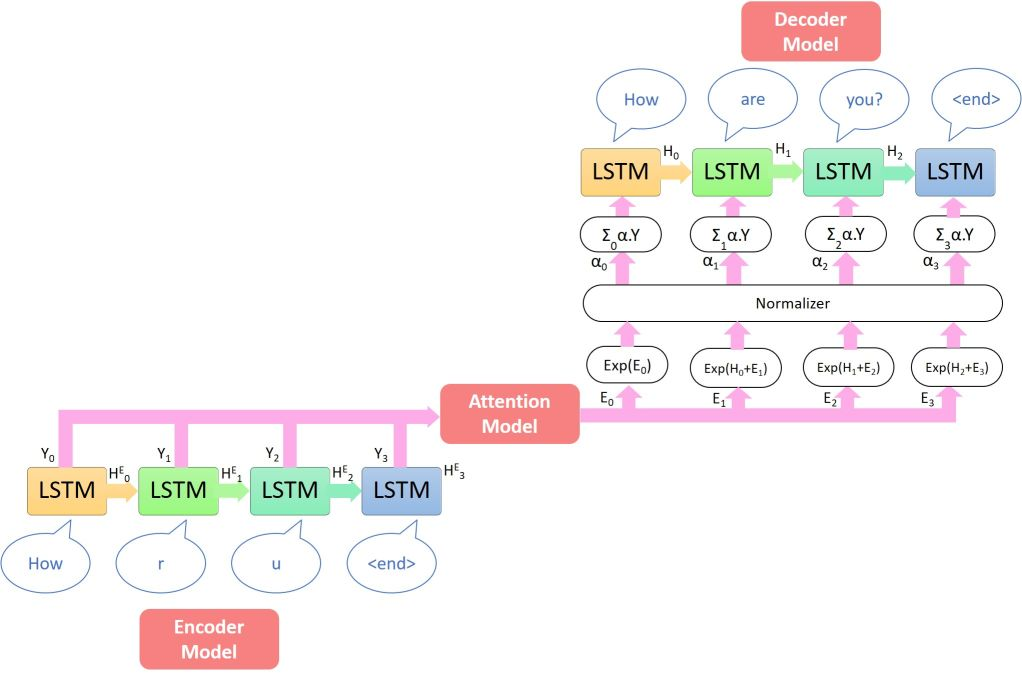

In [1]:
from IPython.display import Image
Image(filename = "Attention.jpg")

<p class = "text">
The figure above shows the mechanism of attention based encoder decoder model. As you can see, the encoder model only differs from a simple encoder decoder model in that it generates an output for each timestep alongwith the hidden state. All the encoder outputs are then fed to the attention model, where the weights corresponding to all the encoder outputs are calculated to enable the decoder to focus on certain tokens while making predictions. The input to the decoder is then computed by weighing the ground truth token with exponent of a concatenated output of hidden state at previous timestep and attention weights to make a prediction.
</p>

<p class = "text">
The important part of attention model is to calculate the weights of output encoder tokens also known as attention weights. These weights are computed by using specific scoring functions. We will consider three types of scoring functions in this case study namely Dot, General and Concat.
</p>

\begin{align}
H_t\ &=\ \sum_{i}^{}\alpha\ .\ Y
\\
\alpha_t\ &=\ \frac{exp(E_t)}{\sum_{}^{}exp(E_t)}
\\
\\
E_t\ &=\ H_{t}^{\ T}\ Y_i\ &\text{Dot}
\\
&=\ H_{t}^{\ T}\ \ W\ Y_i\ &\text{General}
\\
&=\ v^{\ T}\ tanh(W\ [H_t,\ Y_i])\ &\text{Concat}
\end{align}

<p class = "text">
Hence, in total we will train three Attention based Encoder Decoder models using Dot, General and Concat scoring functions.
</p>

<h2>2. Loading and Preprocessing Data:</h2>
<p class = "text">
As we saw with simple encoder decoder model, the data scarcity is hampering the performance badly. Hence, here we will try data augmnetation techniques as well.
</p>

<h3>2.1. Loading data:</h3>
<p class = "text">
First, we will load the dataset and won't preprocess it here as we have to augment it as well.
</p>

In [2]:
# Reading the file
f = open("en2cn-2k.en2nen2cn", "r", encoding = 'utf-8')
text = f.read()
# Removing last instance after splitting as it is empty string
text = text.split('\n')[:-1]
# Creating the pandas dataframe
data = [[text[i], text[i+1]] for i in list(range(0, 6000, 3))]
df = pd.DataFrame(data, columns = ['Informal text', 'Formal text'])
df.head()

,Informal text,Formal text
0,"U wan me to ""chop"" seat 4 u nt?",Do you want me to reserve seat for you or not?
1,Yup. U reaching. We order some durian pastry a...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,I'm Thai. What do you do?
4,Hi! How did your week go? Haven heard from you...,Hi! How did your week go? Haven't heard from y...


<h3>2.2. Augmenting the Dataset:</h3>
<p class = "text">
For data augmentation, we can use <code>nlpaug</code> library. For our purpose, synonym augmentation and spelling augmentation are the suitable techniques. For each formal sentence in the dataset, we will first add synonym augmented pairs to get 4000 instances. On top of that, we will apply spelling augmnetations to get 8000 instances in total.
</p>

In [3]:
# Applying Synonym augmentation
aug = naw.SynonymAug(aug_src = 'wordnet')
for text in df['Formal text'].values:
    augmented = pd.DataFrame({"Informal text":[aug.augment(text)], "Formal text":[text]})
    df = df.append(augmented, ignore_index = True)
# Applying Spelling augmentation
aug = naw.SpellingAug()
for text in df['Formal text'].values:
    augmented = pd.DataFrame({"Informal text":[aug.augment(text)], "Formal text":[text]})
    df = df.append(augmented, ignore_index = True)
df.tail()

,Informal text,Formal text
7995,Hmm. I think I uauslly boock on weenkends. It ...,Hmm. I think I usually book on weekends. It de...
7996,Can uou ask them wheaher they have [[por any s...,Can you ask them whether they have for any sms...
7997,We aru near Coca already.,We are near Coca already.
7998,Hall ereven. Got lectures. And forgte about co...,Hall eleven. Got lectures. And forget about co...
7999,I bring for u. I can not promess you 100% to w...,I bring for you. I can not promise you 100% to...


<h3>2.3. Preprocessing the Dataset:</h3>
<p class = "text">
The models we will design are known as sequence to sequence models as we are providing a text sequence as input and expect the text sequence as output. For that, the input to the encoder should be encoded with start of sentence and end of sentence tokens as it will enable encoder to know span of each sentence. We can use '&lt;' and '&gt;' tokens for initiation and termination respectively. For decoder, input should be appended with '&lt;' token at the beginning and output should be appended with '&gt;' token at the end.
</p>

In [4]:
# Creating encoder inp, decoder inp and decoder_out 
encoder_inp = '<' + df['Informal text'].astype(str) + '>'
decoder_inp = '<' + df['Formal text'].astype(str)
decoder_out = df['Formal text'].astype(str) + '>'
# Creating the dataframe
preprocessed_data = pd.DataFrame()
preprocessed_data['encoder_inp'] = encoder_inp
preprocessed_data['decoder_inp'] = decoder_inp
preprocessed_data['decoder_out'] = decoder_out
preprocessed_data.head()

,encoder_inp,decoder_inp,decoder_out
0,"<U wan me to ""chop"" seat 4 u nt?>",<Do you want me to reserve seat for you or not?,Do you want me to reserve seat for you or not?>
1,<Yup. U reaching. We order some durian pastry ...,<Yeap. You reaching? We ordered some Durian pa...,Yeap. You reaching? We ordered some Durian pas...
2,<They become more ex oredi... Mine is like 25....,<They become more expensive already. Mine is l...,They become more expensive already. Mine is li...
3,<I'm thai. what do u do?>,<I'm Thai. What do you do?,I'm Thai. What do you do?>
4,<Hi! How did your week go? Haven heard from yo...,<Hi! How did your week go? Haven't heard from ...,Hi! How did your week go? Haven't heard from y...


<h3>2.4. Splitting the data into training and validation sets:</h3>
<p class = "text">
Before we split the data, we will look at the distribution of lengths of encoder inp, decoder inp and decoder_out to get the idea of input shape we will need to embed our data into.
</p>

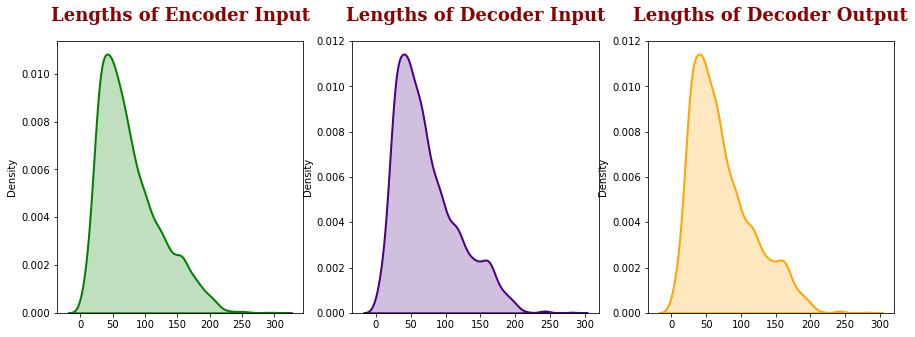

In [5]:
# creating axes to draw plots
fig, ax = plt.subplots(1, 3)

# plotting the distributions
sns.distplot(preprocessed_data['encoder_inp'].apply(len).values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green", ax = ax[0])
sns.distplot(preprocessed_data['decoder_inp'].apply(len).values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "indigo", ax = ax[1])
sns.distplot(preprocessed_data['decoder_out'].apply(len).values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "orange", ax = ax[2])

# adding titles to the subplots
ax[0].set_title("Lengths of Encoder Input", fontdict = title_font, pad = 20.0)
ax[1].set_title("Lengths of Decoder Input", fontdict = title_font, pad = 20.0)
ax[2].set_title("Lengths of Decoder Output", fontdict = title_font, pad = 20.0)

# rescaling the figure
fig.set_figheight(5)
fig.set_figwidth(15)

<p class = "text">
As we can see, most of the sentences are of length around 50 and almost all the sentences have lengths less than 200. Hence, we can filter out the sentences which are of length more than 200.
</p>

In [6]:
# Filtering out sentences of length more than 200
preprocessed_data = preprocessed_data[preprocessed_data['encoder_inp'].apply(len) <= 200]
preprocessed_data = preprocessed_data[preprocessed_data['decoder_inp'].apply(len) <= 200]
preprocessed_data = preprocessed_data[preprocessed_data['decoder_out'].apply(len) <= 200]
preprocessed_data.head()

,encoder_inp,decoder_inp,decoder_out
0,"<U wan me to ""chop"" seat 4 u nt?>",<Do you want me to reserve seat for you or not?,Do you want me to reserve seat for you or not?>
1,<Yup. U reaching. We order some durian pastry ...,<Yeap. You reaching? We ordered some Durian pa...,Yeap. You reaching? We ordered some Durian pas...
2,<They become more ex oredi... Mine is like 25....,<They become more expensive already. Mine is l...,They become more expensive already. Mine is li...
3,<I'm thai. what do u do?>,<I'm Thai. What do you do?,I'm Thai. What do you do?>
4,<Hi! How did your week go? Haven heard from yo...,<Hi! How did your week go? Haven't heard from ...,Hi! How did your week go? Haven't heard from y...


<p class = "text">
We can now split the data into train, validation and test sets. As we have less data, we will split with about 90:05:05 split to use more data to train the model.
</p>

In [4]:
train, validation = train_test_split(preprocessed_data, test_size = 0.025, random_state = 859)
train, test = train_test_split(train, test_size = 0.025, random_state = 859)
joblib.dump(train, 'train.pkl')
joblib.dump(validation, 'validation.pkl')
joblib.dump(test, 'test.pkl')
print(f"Shape of Training set: {train.shape}")
print(f"Shape of Validation set: {validation.shape}")
print(f"Shape of Test set: {test.shape}")
# for one sentence we will be adding '>' token so that the tokanizer learns the word '>'
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['encoder_inp']= str(train.iloc[0]['encoder_inp']) + '>'

Shape of Training set: (7507, 3)
Shape of Validation set: (198, 3)
Shape of Test set: (193, 3)


<h3>2.5. Tokenizing data:</h3>
<p class = "text">
Tokenizing the data means, encoding the sentences with numbers. The numbers are assigned by an unique id from the vocabulary. So, the particular sentence will be encoded by unique ids of words occuring in that sentence. We will create the two tokenizers each for informal and formal data.
</p>

In [5]:
# Tokenizing informal data with case preservation and excluding common punctuations like .,?!:;
tknizer_informal = Tokenizer(filters = '"#$%&()*+-/=@[\\]^_`{|}~\t\n', lower = False, char_level = True)
tknizer_informal.fit_on_texts(train['encoder_inp'].values)
joblib.dump(tknizer_informal, 'tknizer_informal.pkl')
# Tokenizing formal data with case preservation and excluding common punctuations like .,?!:;
tknizer_formal = Tokenizer(filters = '"#$%&()*+-/=@[\\]^_`{|}~\t\n', lower = False, char_level = True)
# Introducing '<end>' token on first sentence so that vocabulary learns it
train['decoder_inp'].iloc[0] = train['decoder_inp'].iloc[0] + '>'
tknizer_formal.fit_on_texts(train['decoder_inp'].values)
joblib.dump(tknizer_formal, 'tknizer_formal.pkl')
# Printing sizes of vocabularies
vocab_size_informal = len(tknizer_informal.word_index.keys())
print(f"Vocab size of Informal text: {vocab_size_informal}")
vocab_size_formal = len(tknizer_formal.word_index.keys())
print(f"Vocab size of Formal text: {vocab_size_formal}")

Vocab size of Informal text: 120
Vocab size of Formal text: 92


<h3>2.6. Padding data:</h3>
<p class = "text">
Padding refers to appending a common id (i.e. generally 0) to make all the sentences of same length. As we saw earlier, we can make the sentence lengths as 200.
</p>

In [ ]:
# Encoding the sentences by numerical ids in place of words
encoder_seq = tknizer_informal.texts_to_sequences(train['encoder_inp'].values)
decoder_inp_seq = tknizer_formal.texts_to_sequences(train['decoder_inp'].values)
decoder_out_seq = tknizer_formal.texts_to_sequences(train['decoder_out'].values)
# Padding the sentences to make all the sentences of same length
encoder_seq = pad_sequences(encoder_seq, maxlen = 200, dtype='int32', padding='post')
decoder_inp_seq = pad_sequences(decoder_inp_seq, maxlen = 200, dtype='int32', padding='post')
decoder_out_seq = pad_sequences(decoder_out_seq, maxlen = 200, dtype='int32', padding='post')

<h2>3. Designing the Data Pipeline:</h2>

<p class = "text">
We have to build a data pipeline to train the model as model expects tuples of length batch size of preprocessed data at runtime. We will load the source and target tokenizers and pad the data into sequences. Then, feed it according to the batch size.
</p>

<h3>3.1. Preprocessing the Data:</h3>
<p class = "text">
We will first convert sentences into sequences by tokenizing and padding.
</p>

In [12]:
class Dataset:
    '''
    Generic class used to preprocess the data
    '''
    def __init__(self, data, tknizer_informal, tknizer_formal, max_len):
        '''
        This method intializes input sequences and the tokenizers
        '''
        self.encoder_inps = data['encoder_inp'].values
        self.decoder_inps = data['decoder_inp'].values
        self.decoder_outs = data['decoder_out'].values
        self.tknizer_informal = tknizer_informal
        self.tknizer_formal = tknizer_formal
        self.max_len = max_len

    def __getitem__(self, i):
        '''
        This method tokenizes the data and pads it with zeros to make all the sequences of same length
        '''
        # Tokenizing the sequences by passing them in lists as required by tokenizer
        self.encoder_inp_seq = self.tknizer_informal.texts_to_sequences([self.encoder_inps[i]])
        self.decoder_inp_seq = self.tknizer_formal.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_formal.texts_to_sequences([self.decoder_outs[i]])
        # Padding the sequences with zeros
        self.encoder_inp_seq = pad_sequences(self.encoder_inp_seq, maxlen = self.max_len, dtype = 'int32', padding = 'post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen = self.max_len, dtype = 'int32', padding = 'post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen = self.max_len, dtype = 'int32', padding = 'post')
        return self.encoder_inp_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self):
        '''
        This method is required by model.fit method at runtime to keep logs
        '''
        return len(self.encoder_inps)

<h3>3.2. Creating Dataloader:</h3>
<p class = "text">
we will now design a dataloader which shuffles the preprocessed dataset and returns the tuple of form ([[encoder_inp], [decoder_inp]], decoder_out) at runtime
</p>

In [13]:
class Dataloader(tf.keras.utils.Sequence):    
    '''
    Keras Dataloader instance to feed the model with preprocessed data at runtime
    '''
    def __init__(self, dataset, batch_size = 1):
        '''
        this method initializes preprocessed dataset and batch size
        '''
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))

    def __getitem__(self, i):
        '''
        This method is used to pack the input data in tuples of form ([[encoder_inp], [decoder_inp]], decoder_out)
        '''
        # Tracking indices of start and stop
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        # Creating data in tuples of form ([[encoder_inp], [decoder_inp]], decoder_out)
        batch = [np.squeeze(np.stack(samples, axis = 1), axis = 0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):
        '''
        This method is required by model.fit method at runtime to keep logs
        '''
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        '''
        This method is a callback to shuffle the indices of data on each epoch
        '''
        self.indexes = np.random.permutation(self.indexes)

In [14]:
# Defining parameters
BATCH_SIZE = 128
MAX_LEN = 200
# Preprocessing data
train_dataset = Dataset(train, tknizer_informal, tknizer_formal, MAX_LEN)
validation_dataset  = Dataset(validation, tknizer_formal, tknizer_formal, MAX_LEN)
# Creating Dataloader
train_dataloader = Dataloader(train_dataset, batch_size = BATCH_SIZE)
validation_dataloader = Dataloader(validation_dataset, batch_size = BATCH_SIZE)
# Checking the dimensions 
print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(128, 200) (128, 200) (128, 200)


<h2>4. Designing the Attention based Encoder Decoder Model:</h2>

<h3>4.1. Designing Encoder:</h3>
<p class = "text">
The encoder will take sequential word embeddings of the source sentences as input at each time step, and encode its information in encoded vector using current state and LSTM hidden state. Hence, at the output of encoder, we get an encoded vector of source sentence which can be thought of as latent information vector.
</p>

In [15]:
class Encoder(tf.keras.Model):
    '''
    Encoder model takes a input sequence and returns Encoder outputs as encoder_final_hidden_state, encoder_final_current_state
    '''
    def __init__(self, inp_vocab_size, embedding_dim, lstm_size, input_length):
        '''
          This method intializes the Encoder model.
        '''
        super().__init__()
        # Initializing the parameters
        self.inp_vocab_size = inp_vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_size = lstm_size
        self.input_length = input_length
        # Initializing Embedding layer
        self.embedding = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_dim,
                                   embeddings_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 1, seed = 859),
                                   input_length = self.input_length, mask_zero = True, name = "Encoder_Embedding")
        #Intializing Encoder LSTM layer
        self.lstm1 = LSTM(self.lstm_size, return_state = True, return_sequences = True,
                          kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 859),
                          recurrent_initializer = tf.keras.initializers.orthogonal(seed = 859), name = "Encoder_LSTM1")
        self.lstm2 = LSTM(self.lstm_size, return_state = True, return_sequences = True,
                          kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 859),
                          recurrent_initializer = tf.keras.initializers.orthogonal(seed = 859), name = "Encoder_LSTM2")

    def call(self, input):
        '''
          This method takes a sequence input and the initial states of the Encoder as inputs.
          Sequence input is passed to the Embedding layer and initial states are passed to the LSTM layer of the Encoder model.
          It returns Encoder outputs as last time step's hidden and current states.
        '''
        # Unpacking the input
        input_sequence, states = input[0], input[1]
        # Passing input sequence to embedding layer
        input_embedded = self.embedding(input_sequence)
        # Passing embedidng layer output to lstm layer
        self.enc_output, self.last_hidden_state, self.last_current_state = self.lstm1(input_embedded, initial_state = states)
        self.enc_output, self.last_hidden_state, self.last_current_state = self.lstm2(self.enc_output, [self.last_hidden_state, self.last_current_state])
        # Returning the outputs
        return self.enc_output, self.last_hidden_state, self.last_current_state
      
    def initialize_states(self, batch_size):
      '''
        Given a batch size this method will return intial hidden state and intial current state.
        If batch size is 32, Hidden state is zeros of size [32,lstm_units], current state is zeros is of size [32,lstm_units]
      '''
      self.first_hidden_state, self.first_current_state = tf.zeros([batch_size, self.lstm_size]), tf.zeros([batch_size, self.lstm_size])
      # Returning the initializations
      return self.first_hidden_state, self.first_current_state

<h3>4.2. Designing Attention Model:</h3>
<p class = "text">
Attention model takes two inputs in the form of decoder hidden state of previous timestep and encoder output and calculates attention weights.
</p>

In [16]:
class Attention(tf.keras.Model):
    '''
        Attention model takes two inputs in the form of decoder_hidden_state, encoder_output and 
        returns context vector and attention weights(softmax - scores).
    '''
    def __init__(self, lstm_size, scoring_function):
        super(Attention, self).__init__()
        # Initializing the parameters
        self.lstm_size = lstm_size
        self.scoring_function = scoring_function
        # Initializing weights for 'dot' scoring function
        if self.scoring_function=='dot':
            self.V = tf.keras.layers.Dense(1)
        # Initializing weights for 'general' scoring function
        if scoring_function == 'general':
            self.W = tf.keras.layers.Dense(lstm_size)
        # Initializing weights for 'concat' scoring function
        if scoring_function == 'concat':
            self.W1 = tf.keras.layers.Dense(lstm_size)
            self.W2 = tf.keras.layers.Dense(lstm_size)
            self.V = tf.keras.layers.Dense(1)
        
    def call(self,input):
        '''
            Attention model takes two inputs in the form of decoder_hidden_state and all the encoder_outputs.
            Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
            Multiply the score function with your encoder_outputs to get the context vector.
            Returns context vector and attention weights(softmax - scores)
        '''
        # Unpacking the input
        decoder_hidden_state, encoder_output = input[0], input[1]
        if self.scoring_function == 'dot':
            # Implement Dot score function here
            query_with_time_axis = tf.expand_dims(decoder_hidden_state, 1)
            score = self.V(tf.linalg.matmul(encoder_output, query_with_time_axis, transpose_a=False, transpose_b=True))
            
        elif self.scoring_function == 'general':
            # Implement General score function here
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis = 2)
            output = self.W(encoder_output)
            score = tf.keras.layers.Dot(axes=(2, 1))([output, decoder_hidden_state])
        if self.scoring_function == 'concat':
            # Implement General score function here
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)      
            score = self.V(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output)))
        # Calculating context vector and attention weights
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

<h3>4.3. Designing Timestep Decoder:</h3>
<p class = "text">
For each time step, Timestep decoder will implement concatenation operation on output of previous timestep of decoder and attention weights computed by attention model.
</p>

In [17]:
class Timestep_Decoder(tf.keras.Model):
    '''
        Timestep Decoder model takes one input token at a time and returns final hidden state of the LSTM unit
    '''
    def __init__(self, out_vocab_size, embedding_dim, input_length, lstm_size, scoring_function, embedding_matrix = None):
        # Initialize the parameters
        super().__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.lstm_size = lstm_size
        self.scoring_function = scoring_function
        self.attention = Attention(self.lstm_size, self.scoring_function)
        self.embedding_matrix = embedding_matrix
        # Initializing Embedding layer based on the availability of Embedding matrix
        if self.embedding_matrix is None:
            self.embedding = Embedding(input_dim = self.out_vocab_size, output_dim = self.embedding_dim,
                                       embeddings_initializer = tf.keras.initializers.RandomNormal(mean = 0, stddev = 1, seed = 859),
                                       input_length = self.input_length, mask_zero = True, name = "embedding_layer_decoder")
        else:
            self.embedding = Embedding(input_dim = self.out_vocab_size, output_dim = self.embedding_dim,
                                       input_length = self.input_length, mask_zero = True, name = "embedding_layer_decoder",
                                       embeddings_initializer = tf.keras.initializers.Constant(self.embedding_matrix), trainable = False)
        #Intialize Decoder LSTM layer
        self.lstm1 = LSTM(self.lstm_size, return_state = True, return_sequences = True,
                          kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 859),
                          recurrent_initializer = tf.keras.initializers.orthogonal(seed = 859), name = "Timestep_Decoder_LSTM1")
        self.lstm2 = LSTM(self.lstm_size, return_state = True, return_sequences = True,
                          kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 859),
                          recurrent_initializer = tf.keras.initializers.orthogonal(seed = 859), name = "Timestep_Decoder_LSTM2")
        #Intialize Dense layer(tar_vocab_size) without activation='softmax'
        self.dense = Dense(out_vocab_size)


    def call(self, input):
        '''
            Timestep decoder model generates final lstm unit hidden state depending on input token and earlier encoder states
        '''
        # Unpacking the input
        input_token, encoder_output, encoder_hidden, encoder_current = input[0], input[1], input[2], input[3]
        # Passing the decoder_input to the embedding layer
        embedded_token = self.embedding(input_token)
        # Passing encoder hidden and encoder output to attention model to get context vector
        context_vector, attention_weights = self.attention([encoder_hidden, encoder_output])
        # Reshaping context vector for concatenation
        query_with_time_axis = tf.expand_dims(context_vector, 1)
        # Concatenating context vector and embedded token
        out_concat = tf.concat([query_with_time_axis, embedded_token], axis = -1)
        # Getting final lstm hidden state
        dec_output, encoder_hidden, encoder_current = self.lstm1(out_concat, [encoder_hidden, encoder_current])
        dec_output, encoder_hidden, encoder_current = self.lstm2(dec_output, [encoder_hidden, encoder_current])
        # Weighing decoder output by output vocabulary size
        out = self.dense(tf.reshape(dec_output, (-1, dec_output.shape[2])))
        # Returning the output
        return out, encoder_hidden, encoder_current

<h3>4.4. Designing Decoder:</h3>
<p class = "text">
Decoder model simply calls timestep decoder at each timestep and generates the final output tokens.
</p>

In [18]:
class Decoder(tf.keras.Model):
    '''
        Decoder model generates the final output tokens by passing it all the encoder states and decoder input sequence
    '''
    def __init__(self, out_vocab_size, embedding_dim, input_length, lstm_size, scoring_function, embedding_matrix = None):
        super().__init__()
        # Intializing the parameters
        self.out_vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.lstm_size = lstm_size
        self.scoring_function = scoring_function
        self.embedding_matrix = embedding_matrix
        # Initializing Timestep decoder instance
        self.timestepdecoder = Timestep_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length,
                                                self.lstm_size, self.scoring_function, self.embedding_matrix)
    @tf.function
    def call(self, input):
        '''
            According to the length of the decoder input sequence, returns a tensor of sequence of decoded tokens as output 
        '''
        # Unpacking the input
        decoder_input, encoder_output, encoder_hidden, encoder_current = input[0], input[1], input[2], input[3]
        # Initializing an empty Tensor array, that will store the outputs at each and every time step
        all_outputs = tf.TensorArray(tf.float32, size = tf.shape(decoder_input)[1], name = "output_array")
        # Iterating till the length of the decoder input
        loop = tf.shape(decoder_input)[1]
        for timestep in range(loop):
            # Calling the Timestep Decoder for each token in decoder input
            output, encoder_hidden, encoder_current = self.timestepdecoder([decoder_input[:, timestep:timestep+1], encoder_output, encoder_hidden, encoder_current])
            # Storing the output in tensorarray
            all_outputs = all_outputs.write(timestep, output)
        # Reshaping the tensor array
        all_outputs = tf.transpose(all_outputs.stack(), [1,0,2])
        # Returning the tensor array
        return all_outputs

<h3>4.5. Designing Final Model Architechture:</h3>
<p class = "text">
Attention based Encoder Decoder model gets the tuple of input sequences as input and implements the Encoder, Attention, Timestep Decoder and Decoder models using subclassing API.
</p>

In [19]:
class Attention_Based_Encoder_Decoder(tf.keras.Model):
    '''
    The Attention_Based_Encoder_Decoder Model initializes both Encoder and Decoder Models and outputs normalized probabilties of the tokens in target vocabulary.
    '''
    def __init__(self, input_length, inp_vocab_size, out_vocab_size, lstm_size, scoring_function, batch_size, embedding_dim, embedding_matrix = None):
        '''
          This method intializes the both the Encoder and Decoder models
        '''
        super().__init__()
        # Initializing the parameters
        self.input_length = input_length
        self.inp_vocab_size = inp_vocab_size + 1
        self.out_vocab_size = out_vocab_size + 1
        self.lstm_size = lstm_size
        self.scoring_function = scoring_function
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.embedding_matrix = embedding_matrix
        #Creating Encoder model object
        self.encoder = Encoder(inp_vocab_size = self.inp_vocab_size, embedding_dim = self.embedding_dim, lstm_size = self.lstm_size, input_length = self.input_length)
        #Creating Decoder model object
        self.decoder = Decoder(out_vocab_size = self.out_vocab_size, embedding_dim = self.embedding_dim, lstm_size = self.lstm_size,
                               scoring_function = self.scoring_function, input_length = self.input_length, embedding_matrix = self.embedding_matrix)
    
    def call(self, data):
        '''
        This method takes data from data pipeline in tuples of length 2, where first is encoder_inp and second is decoder_inp
        encoder_inp is fed to Encoder model object alongwith initial states whereas decoder_inp is fed to decoder model object alongwith
        Encoder last hidden and current states.
        The Model then returns normalized output probabilities of tokens in target vocabulary.
        '''
        # Unpacking data
        enc_inp, dec_inp = data[0], data[1]
        # Initializing Encoder initial states
        initial_state = self.encoder.initialize_states(self.batch_size)
        # Calling Encoder model object
        encoder_output, encoder_hidden, encoder_current = self.encoder([enc_inp, initial_state])
        # Calling Decoder model object
        final_output = self.decoder([dec_inp, encoder_output, encoder_hidden, encoder_current])
        return final_output

<h2>5. Designing the Model Pipeline:</h2>

<h3>5.1. Creating Custom Loss Function:</h3>
<p class = "text">
We will now create a custom loss Function that will mask the padded zeros while for more reliable loss calculation.
</p>

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

@tf.function
def loss_function(real, pred):
    # Custom loss function that will not consider the loss for padded zeros.
    # Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention
    # optimizer = tf.keras.optimizers.Adam()
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

<h3>5.2. Creating Tensorboard Callback:</h3>
<p class = "text">
To keep track of loss while training the model, we will create a Tensorboard callback by providing log directory.
</p>

In [21]:
def create_tensorboard_cb(model):
    '''
    Takes path string as input and returns tensorboard callback initialized in that path.
    '''
    import time
    root_logdir = os.path.join(os.curdir, model)
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    logdir = os.path.join(root_logdir, run_id)
    return tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)

<h3>5.3. Creating Predict Function:</h3>
<p class = "text">
The <code>predict</code> function will take as informal input sentence and model instance with which to predict as input and return the output as prediction.
</p>

In [22]:
def predict(input_sentence, model):
    '''
    Takes input sentence and model instance as inputs and predicts the output.
    The prediction is done by using following steps:
    Step A. Given input sentence, preprocess the punctuations, convert the sentence into integers using tokenizer used earlier.
    Step B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    Step C. Initialize index of '<' as input to decoder. and encoder final states as input_states to decoder
    Step D. Till we reach max_length of decoder or till the model predicted word '>':
            pass the inputs to timestep decoder at each timestep, update the hidden states and get the output token
    Step E. Return the predicted sentence.
    '''
    # Tokenizing and Padding the sentence
    inputs = [tknizer_informal.word_index.get(i, 0) for i in input_sentence]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen = MAX_LEN, padding = 'post')
    inputs = tf.convert_to_tensor(inputs)
    # Initializing result string and hidden states
    result = ''
    hidden = tf.zeros([1, UNITS]), tf.zeros([1, UNITS])
    # Getting Encoder outputs
    enc_out, state_h, state_c = model.encoder(inputs, hidden)
    dec_hidden = [state_h, state_c]
    dec_input = tf.expand_dims([tknizer_formal.word_index['<']], 0)
    # Running loop until max length or the prediction is '>' token
    for t in range(MAX_LEN):
        # Getting Decoder outputs fot timestep t
        output, state_h, state_c = model.decoder.timestepdecoder(dec_input, enc_out, state_h, state_c)
        # Getting token index having highest probability
        predicted_id = tf.argmax(output[0]).numpy()
        # Getting output token
        if tknizer_formal.index_word.get(predicted_id, '') == '>':
            break
        else:
            result += tknizer_formal.index_word.get(predicted_id, '')
            dec_input = tf.expand_dims([predicted_id], 0)
    # Postprocessing the result string to remove spaces between punctuations
    return result

<h2>6. Training the Model using Dot Scoring Function:</h2>

<h3>6.1. Compiling and Fitting the model:</h3>
<p class = "text">
We can now train the model by using model fit method.
</p>

In [ ]:
tf.random.set_seed(859)
# Defining model parameters
UNITS = 200
EPOCHS = 50
TRAIN_STEPS = train.shape[0]//BATCH_SIZE
VALID_STEPS = validation.shape[0]//BATCH_SIZE
# Defining model instance with 'dot' scoring function
model_dot  = Attention_Based_Encoder_Decoder(input_length = MAX_LEN, inp_vocab_size = vocab_size_informal,
                                             out_vocab_size = vocab_size_formal, lstm_size = UNITS,
                                             scoring_function = 'dot', batch_size = BATCH_SIZE,
                                             embedding_dim = vocab_size_formal, embedding_matrix = None)
# Compiling the model using 'adam' optimizer and custom loss function
optimizer = tf.keras.optimizers.Adam(0.01)
model_dot.compile(optimizer = optimizer, loss = loss_function)
# Creating callbacks to control model training
learning_rate_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, verbose = 1, patience = 1, min_lr = 0.0001)
tensorboard_cb = create_tensorboard_cb("Model_Dot_logs")
stopper_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, restore_best_weights = True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Model_Dot",
                                                    save_best_only = True, save_weights_only = False)
# Fitting the model on training data
model_dot.fit(train_dataloader, steps_per_epoch = TRAIN_STEPS, epochs = EPOCHS,
              callbacks = [learning_rate_cb, tensorboard_cb, stopper_cb, checkpoint_cb],
              validation_data = validation_dataloader, validation_steps = VALID_STEPS)
model_dot.summary()

Epoch 1/50
57/57 [==============================] - 122s 2s/step - loss: 1.1210 - val_loss: 1.0406
Epoch 2/50
57/57 [==============================] - 102s 2s/step - loss: 0.8188 - val_loss: 0.8296
Epoch 3/50
57/57 [==============================] - 101s 2s/step - loss: 0.6637 - val_loss: 0.6886
Epoch 4/50
57/57 [==============================] - 102s 2s/step - loss: 0.5683 - val_loss: 0.6106
Epoch 5/50
57/57 [==============================] - 102s 2s/step - loss: 0.5132 - val_loss: 0.5731
Epoch 6/50
57/57 [==============================] - 102s 2s/step - loss: 0.4758 - val_loss: 0.5366
Epoch 7/50
57/57 [==============================] - 105s 2s/step - loss: 0.4455 - val_loss: 0.5196
Epoch 8/50
57/57 [==============================] - 102s 2s/step - loss: 0.4224 - val_loss: 0.5007
Epoch 9/50
57/57 [==============================] - 101s 2s/step - loss: 0.4036 - val_loss: 0.4801
Epoch 10/50
57/57 [==============================] - 98s 2s/step - loss: 0.3874 - val_loss: 0.4739
Epoch 11/5

<p class = "text">
The model achieves the loss of 0.3774 on validation set which is better than that of simple encoder decoder model. 
</p>

<h3>6.2. Calculating the BLEU Score:</h3>
<p class = "text">
We can now calculate the BLEU score to quantify the model performance. 
</p>

In [ ]:
# Removing '<' and '>' tokens and postprocessing punctuations to make plain texts
def rem(s):
    if s.startswith('<'):
        s = s[1:]
    if s.endswith('>'):
        s = s[:-1]
    return s
test['informals'] = test['encoder_inp'].apply(rem)
test['formals'] = test['decoder_inp'].apply(rem)
def predictor(s):
    # Modifing predictor using dot scoring function
    result = predict(s, model_dot)
    return result
test['predictions'] = test['informals'].apply(predictor)
# Process inputs for Bleu score
def convert_formals(s):
    return [s.split()]
def convert_predictions(s):
    return s.split()
test['formals'] = test['formals'].apply(convert_formals)
test['predictions'] = test['predictions'].apply(convert_predictions)
bleu_scores_dot = [sentence_bleu(test['formals'].iloc[i], test['predictions'].iloc[i]) for i in range(len(test))]
print(f"Mean Bleu score of predictions: {np.mean(bleu_scores_dot)}")

Mean Bleu score of predictions: 0.5053083753162261


<p class = "text">
The model achieves the BLEU score of 0.505  on test set which is significantly better than that of baseline encoder decoder model. Let us check the distribution of the bleu scores.
</p>

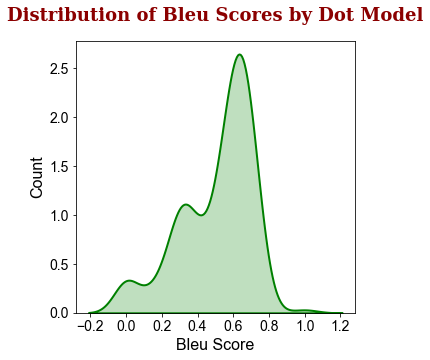

In [8]:
plt.figure(figsize = (5, 5))
ax = sns.distplot(bleu_scores_dot, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green")
plt.title("Distribution of Bleu Scores by Dot Model", fontdict = title_font, pad = 20.0)
plt.xlabel("Bleu Score", fontdict = label_font)
plt.ylabel("Count", fontdict = label_font)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(14)
plt.show()

<p class = "text">
The distribution shows that the model with dot scoring function achieves the bleu score of around 0.7 for majority of the sentences. Let us generate a random prediction using this model.
</p>

In [1]:
print("Informal Sentence: how r u")
print(f"Formal Prediction: {predict('how r u', model_dot)}")

Informal Sentence: how r u
Formal Sentence: How do going to your?


<p class = "text">
The model corrected the word 'how' to 'How' alongwith capitalizing the letter 'h'. It also tried to correct the word 'u' to 'you' but failed instead predicting 'your'. It also introduced the correct punctuation '?'. But more importantly, the prediction is not meaningful or convincing. This issue can be overcome by training the model on large dataset. 
</p>

<h2>7. Training the Model using General Scoring Function:</h2>

<h3>7.1. Compiling and Fitting the model:</h3>
<p class = "text">
We can now train the model by using model fit method.
</p>

In [ ]:
tf.random.set_seed(859)
# Defining model instance with 'general' scoring function
model_general  = Attention_Based_Encoder_Decoder(input_length = MAX_LEN, inp_vocab_size = vocab_size_informal,
                                             out_vocab_size = vocab_size_formal, lstm_size = UNITS,
                                             scoring_function = 'general', batch_size = BATCH_SIZE,
                                             embedding_dim = vocab_size_formal, embedding_matrix = None)
# Compiling the model using 'adam' optimizer and custom loss function
optimizer = tf.keras.optimizers.Adam(0.01)
model_general.compile(optimizer = optimizer, loss = loss_function)
# Creating callbacks to control model training
tensorboard_cb = create_tensorboard_cb("Model_General_logs")
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Model_General",
                                                    save_best_only = True, save_weights_only = False)
# Fitting the model on training data
model_general.fit(train_dataloader, steps_per_epoch = TRAIN_STEPS, epochs = EPOCHS,
              callbacks = [learning_rate_cb, tensorboard_cb, stopper_cb, checkpoint_cb],
              validation_data = validation_dataloader, validation_steps = VALID_STEPS)
model_general.summary()

Epoch 1/50
57/57 [==============================] - 129s 2s/step - loss: 1.1200 - val_loss: 1.0382
Epoch 2/50
57/57 [==============================] - 111s 2s/step - loss: 0.8096 - val_loss: 0.7968
Epoch 3/50
57/57 [==============================] - 110s 2s/step - loss: 0.6537 - val_loss: 0.6525
Epoch 4/50
57/57 [==============================] - 110s 2s/step - loss: 0.5507 - val_loss: 0.6274
Epoch 5/50
57/57 [==============================] - 110s 2s/step - loss: 0.4919 - val_loss: 0.5500
Epoch 6/50
57/57 [==============================] - 110s 2s/step - loss: 0.4539 - val_loss: 0.5078
Epoch 7/50
57/57 [==============================] - 109s 2s/step - loss: 0.4239 - val_loss: 0.4900
Epoch 8/50
57/57 [==============================] - 109s 2s/step - loss: 0.4014 - val_loss: 0.4712
Epoch 9/50
57/57 [==============================] - 109s 2s/step - loss: 0.3807 - val_loss: 0.4567
Epoch 10/50
57/57 [==============================] - 109s 2s/step - loss: 0.3664 - val_loss: 0.4445
Epoch 11/

In [89]:
# Fitting the model on training data
model_general.fit(train_dataloader, steps_per_epoch = TRAIN_STEPS, epochs = EPOCHS,
              callbacks = [learning_rate_cb, tensorboard_cb, stopper_cb, checkpoint_cb],
              validation_data = validation_dataloader, validation_steps = VALID_STEPS)
model_general.summary()

Epoch 1/50
57/57 [==============================] - 121s 2s/step - loss: 0.1078 - val_loss: 0.2256
Epoch 2/50
57/57 [==============================] - 114s 2s/step - loss: 0.1016 - val_loss: 0.2244
Epoch 3/50
57/57 [==============================] - 113s 2s/step - loss: 0.0984 - val_loss: 0.2227
Epoch 4/50
57/57 [==============================] - 114s 2s/step - loss: 0.0968 - val_loss: 0.2236
Epoch 5/50
57/57 [==============================] - 114s 2s/step - loss: 0.0957 - val_loss: 0.2241

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 6/50
57/57 [==============================] - 113s 2s/step - loss: 0.0936 - val_loss: 0.2196
Epoch 7/50
57/57 [==============================] - 113s 2s/step - loss: 0.0917 - val_loss: 0.2214
Epoch 8/50
57/57 [==============================] - 112s 2s/step - loss: 0.0906 - val_loss: 0.2213

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 9/50
57/57 [===========================

<p class = "text">
The model achieves the loss of 0.2196 on validation set which is better than the model using dot scoring function.
</p>

<h3>7.2. Calculating the BLEU Score:</h3>
<p class = "text">
We can now calculate the BLEU score to quantify the model performance. 
</p>

In [90]:
# Removing '<' and '>' tokens and postprocessing punctuations to make plain texts
def rem(s):
    if s.startswith('<'):
        s = s[1:]
    if s.endswith('>'):
        s = s[:-1]
    return s
test['informals'] = test['encoder_inp'].apply(rem)
test['formals'] = test['decoder_inp'].apply(rem)
def predictor(s):
    # Modifing predictor using general scoring function
    result = predict(s, model_general)
    return result
test['predictions'] = test['informals'].apply(predictor)
# Process inputs for Bleu score
def convert_formals(s):
    return [s.split()]
def convert_predictions(s):
    return s.split()
test['formals'] = test['formals'].apply(convert_formals)
test['predictions'] = test['predictions'].apply(convert_predictions)
bleu_scores_gen = [sentence_bleu(test['formals'].iloc[i], test['predictions'].iloc[i]) for i in range(len(test))]
print(f"Mean Bleu score of predictions: {np.mean(bleu_scores_gen)}")

Mean Bleu score of predictions: 0.5096058330933692


<p class = "text">
The model achieves the BLEU score of 0.5096 on test set which is significantly better than that of baseline encoder decoder model. Let us check the distribution of the bleu scores.
</p>

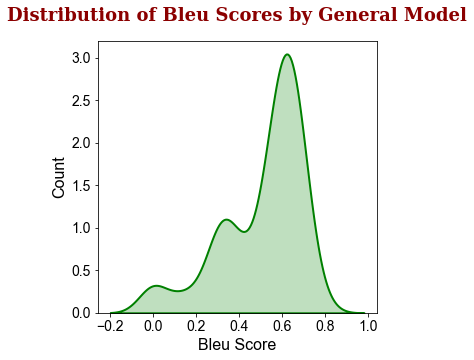

In [9]:
plt.figure(figsize = (5, 5))
ax = sns.distplot(bleu_scores_gen, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green")
plt.title("Distribution of Bleu Scores by General Model", fontdict = title_font, pad = 20.0)
plt.xlabel("Bleu Score", fontdict = label_font)
plt.ylabel("Count", fontdict = label_font)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(14)
plt.show()

<p class = "text">
The distribution shows that the model with general scoring function achieves the bleu score of around 0.6 for majority of the sentences but is somewhat better than the dot model. Let us generate a random prediction using this model.
</p>

In [2]:
print("Informal Sentence: how r u")
print(f"Formal Prediction: {predict('how r u', model_general)}")

Informal Sentence: how r u
Formal Prediction: How are you?


<p class = "text">
As expected with the lower validation loss, unlike the model with dot scoring function, the model is predicting pretty accurately. 
</p>

<h2>8. Training the Model using Concat Scoring Function:</h2>

<h3>8.1. Compiling and Fitting the model:</h3>
<p class = "text">
We can now train the model by using model fit method.
</p>

In [ ]:
# Defining model instance with 'concat' scoring function
model_concat  = Attention_Based_Encoder_Decoder(input_length = MAX_LEN, inp_vocab_size = vocab_size_informal,
                                             out_vocab_size = vocab_size_formal, lstm_size = UNITS,
                                             scoring_function = 'concat', batch_size = BATCH_SIZE,
                                             embedding_dim = vocab_size_formal, embedding_matrix = None)
# Compiling the model using 'adam' optimizer and custom loss function
optimizer = tf.keras.optimizers.Adam(0.01)
model_concat.compile(optimizer = optimizer, loss = loss_function)
# Creating callbacks to control model training
tensorboard_cb = create_tensorboard_cb("Model_Concat_logs")
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Model_Concat",
                                                    save_best_only = True, save_weights_only = False)
# Fitting the model on training data
model_concat.fit(train_dataloader, steps_per_epoch = TRAIN_STEPS, epochs = EPOCHS,
              callbacks = [learning_rate_cb, tensorboard_cb, stopper_cb, checkpoint_cb],
              validation_data = validation_dataloader, validation_steps = VALID_STEPS)
model_concat.summary()

Epoch 1/50
57/57 [==============================] - 147s 2s/step - loss: 1.0973 - val_loss: 0.9655
Epoch 2/50
57/57 [==============================] - 126s 2s/step - loss: 0.7658 - val_loss: 0.7458
Epoch 3/50
57/57 [==============================] - 127s 2s/step - loss: 0.6057 - val_loss: 0.6164
Epoch 4/50
57/57 [==============================] - 127s 2s/step - loss: 0.5203 - val_loss: 0.5795
Epoch 5/50
57/57 [==============================] - 126s 2s/step - loss: 0.4742 - val_loss: 0.5523
Epoch 6/50
57/57 [==============================] - 125s 2s/step - loss: 0.4432 - val_loss: 0.5233
Epoch 7/50
57/57 [==============================] - 125s 2s/step - loss: 0.4190 - val_loss: 0.5048
Epoch 8/50
57/57 [==============================] - 125s 2s/step - loss: 0.3997 - val_loss: 0.4880
Epoch 9/50
57/57 [==============================] - 127s 2s/step - loss: 0.3838 - val_loss: 0.4823
Epoch 10/50
57/57 [==============================] - 127s 2s/step - loss: 0.3695 - val_loss: 0.4747
Epoch 11/

<p class = "text">
The model achieves the loss of 0.4160 on validation set which is not better than the model using general scoring function.
</p>

<h3>8.2. Calculating the BLEU Score:</h3>
<p class = "text">
We can now calculate the BLEU score to quantify the model performance. 
</p>

In [ ]:
# Removing '<' and '>' tokens and postprocessing punctuations to make plain texts
def rem(s):
    if s.startswith('<'):
        s = s[1:]
    if s.endswith('>'):
        s = s[:-1]
    return s
test['informals'] = test['encoder_inp'].apply(rem)
test['formals'] = test['decoder_inp'].apply(rem)
def predictor(s):
    # Modifing predictor using concat scoring function
    result = predict(s, model_concat)
    return result
test['predictions'] = test['informals'].apply(predictor)
# Process inputs for Bleu score
def convert_formals(s):
    return [s.split()]
def convert_predictions(s):
    return s.split()
test['formals'] = test['formals'].apply(convert_formals)
test['predictions'] = test['predictions'].apply(convert_predictions)
bleu_scores_con = [sentence_bleu(test['formals'].iloc[i], test['predictions'].iloc[i]) for i in range(len(test))]
print(f"Mean Bleu score of predictions: {np.mean(bleu_scores_con)}")

Mean Bleu score of predictions: 0.45978226278062007


<p class = "text">
The model achieves the BLEU score of 0.459  on test set which is significantly better than that of baseline encoder decoder model. Let us check the distribution of the bleu scores.
</p>

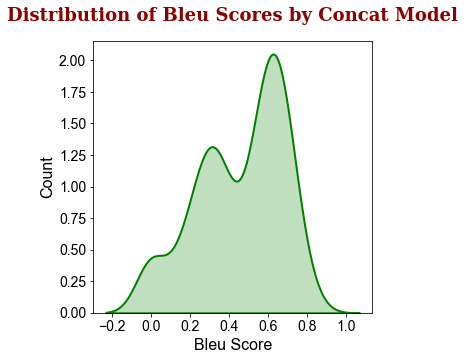

In [12]:
plt.figure(figsize = (5, 5))
ax = sns.distplot(bleu_scores_con, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, color = "green")
plt.title("Distribution of Bleu Scores by Concat Model", fontdict = title_font, pad = 20.0)
plt.xlabel("Bleu Score", fontdict = label_font)
plt.ylabel("Count", fontdict = label_font)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(14)
plt.show()

<p class = "text">
The distribution shows that the model with concat scoring function achieves the bleu score of around 0.65 for majority of the sentences but is somewhat better than the general model. Let us generate a random prediction using this model.
</p>

In [3]:
print("Informal Sentence: how r u")
print(f"Formal Prediction: {predict('wat r ya talkin abt', model_concat)}")

Informal Sentence: how r u
Formal Prediction: Have are it it it.


<p class = "text">
The model corrected the informal word 'r' to 'are'. It also corrected the capitalization. But more importantly, the prediction is not meaningful or convincing. This issue can be overcome by training the model on large dataset. 
</p>

<h2>9. Error Analysis:</h2>

<p class = "text">
The model with general scoring function has performed best among the three models. Now, we will analyze the behaviour of this model on test dataset by checking the best and worst predictions made by the model. For that we will have to sort the bleu scores achieved by the model on the test set, and then print the corresponding predictions.
</p>

In [14]:
# Sorting the indices by blue scores
scores = np.array(bleu_scores_gen)
indices = np.argsort(scores)
# Getting worst score indices
worst = indices[:5]
# Getting best score indices
best = indices[-5:][::-1]
print('Best Predictions:')
print("-"*50)
for i in best:
    print(f"Informal Input : {test['informals'].iloc[i]}")
    print(f"Expected Output : {' '.join(test['formals'].iloc[i][0])}")
    print(f"Predicted Output : {' '.join(test['predictions'].iloc[i])}")
    print(f"Bleu Score of Prediction : {scores[i]}")
    print("\n")
print('='*100)
print('Worst Predictions:')
print("-"*50)
for i in worst:
    print(f"Informal Input : {test['informals'].iloc[i]}")
    print(f"Expected Output : {' '.join(test['formals'].iloc[i][0])}")
    print(f"Predicted Output : {' '.join(test['predictions'].iloc[i])}")
    print(f"Bleu Score of Prediction : {scores[i]}")
    print("\n")

Best Predictions:
--------------------------------------------------
Informal Input : Okay.
Expected Output : Ok.
Predicted Output : Ok.
Bleu Score of Prediction : 1.0


Informal Input : So what are you doing now? Can 1 pastime you to a walk? See? Then Iodin maybe pass in by where you bequeath later.
Expected Output : So what are you doing now? Can I interest you to a walk? See? Then I maybe pass in by where you leave later.
Predicted Output : No. I just want to watch that someone ask you a few dollars on Friday. So if you want to go for the party.
Bleu Score of Prediction : 0.7071067811865476


Informal Input : You prefer other day's onr lyou want Monday em Thursday soy you can comming directly? Or DO you have fire days? You choose, because you aire the only on studying.
Expected Output : You prefer other days or you want Monday and Thursday so you can come directly? Or do you have free days? You choose, because you are the only one studying.
Predicted Output : You are having a good t

<p class = "text">
The important observation regarding the predictions is that be it best predictions or worst predictions, the model is capable of correcting the misspellings, capitalizations, and punctuations. The predictions with higher bleu score have more words overlapping with ground truth. The worst predictions however, are for the instances where there are lot of misspellings and incorrect capitalizations as the model is sensitive to it. Nevertheless, the model is trained on very little data and hence has lot of scope for improvement with large datasets like GYAFC corpus.
</p>

<h2>9. Summary:</h2>

<p class = "text">
The model with dot scoring function did not generate a satisfactory prediction. But model with general scoring function performed excepationally well in terms of meaning preservation also it achieved the lowest validation loss. Model with concat scoring function is performing well too. While data augmentation and introduction of attention model significantly improves the performance, it can be further improved by using large dataset. For now though, the model with general scoring function is suitable for our deployment purposes.
</p>